In [338]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as st
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from scipy import stats

import warnings
warnings.filterwarnings('ignore')

<h1>Upsell</h1>

In [339]:
df = pd.read_csv('data_preprocessed_sort.csv')

In [341]:
def segment_region(region):
    if region == 'no' or region == 'rural':
        return 0
    else:
        return 1
df['segment_region'] = df['region_size'].apply(segment_region)

def upsell_flg(functional):
    if functional == 'Upsell':
        return 1
    else:
        return 0
df['upsell_flg'] = df['functional_cd'].apply(upsell_flg)

In [337]:
df.groupby(['functional_cd', 'product_cd']).product_cd.size()

functional_cd  product_cd        
Activation     Car Loan                 1
               Cash Loan               86
Afterfilling   Car Loan                 3
               Casco                  220
               Cash Loan              104
               Credit Cards           486
               Debit Cards            140
               Investment              14
               MVNO                   878
               Mortgage Insurance      34
               Secured Loan            13
Agreement      Car Loan               135
               Cash Loan              242
               Secured Loan            43
Autoleads      Investment              36
BAF            Debit Cards             66
Cold           Car Loan                 1
               Casco                   16
               Debit Cards            467
               MVNO                   627
               Mortgage Insurance     261
               T-Auto                   2
               Travel Avia              3


In [324]:
df[df['segment_region'] == 1]['functional_cd'].value_counts(normalize=True)

functional_cd
Preapprove       0.477023
Afterfilling     0.138326
Utilization      0.092025
Upsell           0.087742
Cold             0.065980
Meeting          0.045376
Agreement        0.035652
Reutilization    0.015858
Incoming         0.013080
Downsell         0.012386
Activation       0.008913
Autoleads        0.003704
BAF              0.002315
Deposit          0.000926
Prolongation     0.000579
Refinancing      0.000116
Name: proportion, dtype: float64

In [334]:
df.groupby(['gender_cd', 'emp_gender_cd']).approval_flg.mean()

gender_cd  emp_gender_cd
0.0        M                0.076342
           W                0.096309
1.0        M                0.109375
           W                0.107398
Name: approval_flg, dtype: float64

In [323]:
df[df['segment_region'] == 0]['functional_cd'].value_counts(normalize=True)

functional_cd
Preapprove       0.533800
Cold             0.112946
Afterfilling     0.097551
Utilization      0.086634
Meeting          0.060742
Upsell           0.051225
Agreement        0.015675
Incoming         0.014696
Downsell         0.010917
Reutilization    0.006998
BAF              0.006438
Activation       0.001400
Autoleads        0.000560
Deposit          0.000280
Prolongation     0.000140
Name: proportion, dtype: float64

In [267]:
df[(df['functional_cd'] == 'Upsell') | (df['functional_cd'] == 'Downsell')].groupby(['functional_cd', 'segment_region'])['approval_flg'].agg(mean='mean', count='count').reset_index()

,functional_cd,segment_region,mean,count
0,Downsell,0,0.102564,78
1,Downsell,1,0.084112,107
2,Upsell,0,0.073770,366
3,Upsell,1,0.055409,758


In [255]:
df1 = df.groupby(['segment_region', 'crosssell'])['approval_flg'].agg(mean='mean', count='count').reset_index()
df1

,segment_region,crosssell,mean,count
0,0,0,0.097000,6701
1,0,1,0.078829,444
2,1,0,0.111783,7774
3,1,1,0.058960,865


<Axes: xlabel='crosssell', ylabel='mean'>

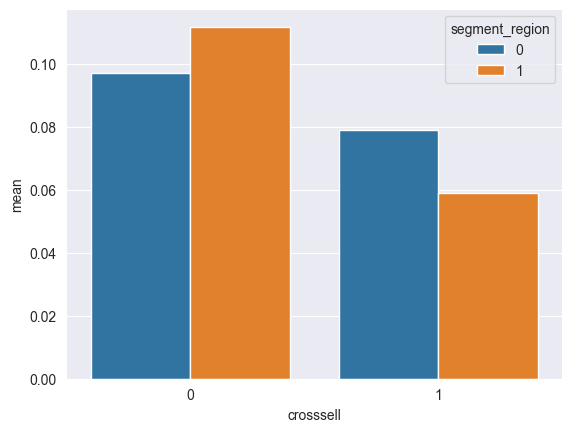

In [261]:
sns.barplot(data=df1, x='crosssell', y='mean', hue='segment_region')

In [271]:
X = df[['crosssell', 'segment_region']]
y = df['approval_flg']

# Добавляем константу для модели
X = sm.add_constant(X)

# Создаем и обучаем линейную регрессионную модель
linear_model = sm.OLS(y, X)
linear_result = linear_model.fit()

# Выводим результаты модели
print(linear_result.summary())

                            OLS Regression Results                            
Dep. Variable:           approval_flg   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     13.29
Date:                Thu, 28 Nov 2024   Prob (F-statistic):           1.70e-06
Time:                        22:24:12   Log-Likelihood:                -3496.8
No. Observations:               15784   AIC:                             7000.
Df Residuals:                   15781   BIC:                             7023.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.0984      0.004     27.

In [272]:
X = df[['crosssell', 'segment_region']]
y = df['approval_flg']

X = sm.add_constant(X)

probit_model = sm.Probit(y, X)
probit_result = probit_model.fit()


print(probit_result.summary())

Optimization terminated successfully.
         Current function value: 0.327859
         Iterations 6
                          Probit Regression Results                           
Dep. Variable:           approval_flg   No. Observations:                15784
Model:                         Probit   Df Residuals:                    15781
Method:                           MLE   Df Model:                            2
Date:                Thu, 28 Nov 2024   Pseudo R-squ.:                0.002771
Time:                        22:24:26   Log-Likelihood:                -5174.9
converged:                       True   LL-Null:                       -5189.3
Covariance Type:            nonrobust   LLR p-value:                 5.687e-07
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -1.2911      0.021    -62.483      0.000      -1.332      -1.251
crosssell        

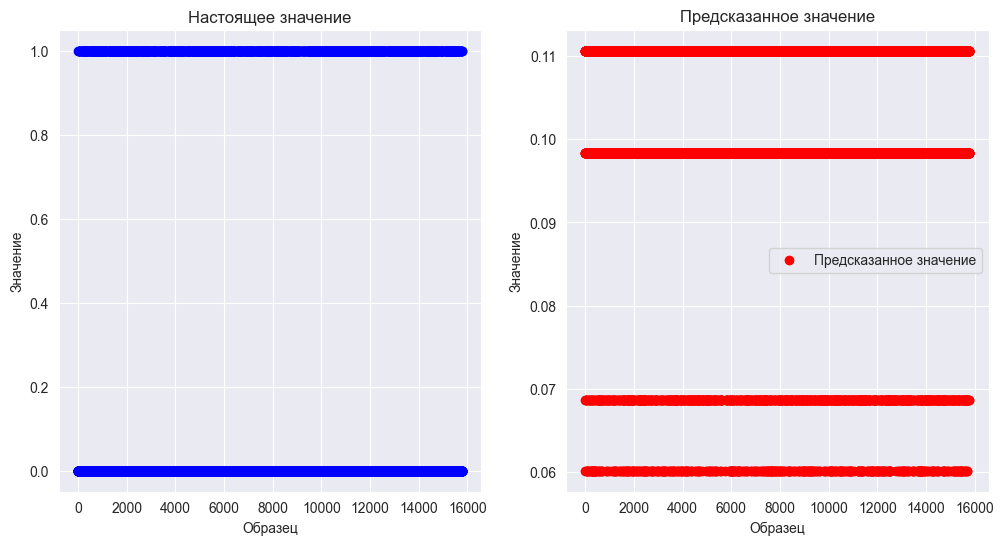

In [275]:
y_pred = probit_result.predict(X)

# Создание графиков
plt.figure(figsize=(12, 6))

# График настоящего значения
plt.subplot(1, 2, 1)
plt.plot(y, 'bo', label='Настоящее значение')
plt.xlabel('Образец')
plt.ylabel('Значение')
plt.title('Настоящее значение')

# График предсказанного значения
plt.subplot(1, 2, 2)
plt.plot(y_pred, 'ro', label='Предсказанное значение')
plt.xlabel('Образец')
plt.ylabel('Значение')
plt.title('Предсказанное значение')

plt.legend()
plt.show()